In [4]:
import sys
sys.path.append('/home/kevinteng/Desktop/BrainTumourSegmentation')
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os, random
import utils
from utils_vis import plot_comparison, plot_labels_color, show_lable_on_image4, plot_labels_color255 
from utils import dice_coef, ss_metric, compute_metric, min_max_norm
import nibabel as nib
import glob
import medpy.io
from array2gif import write_gif
from PIL import Image
%matplotlib inline

---

# Data Plots

(155, 240, 240, 5)



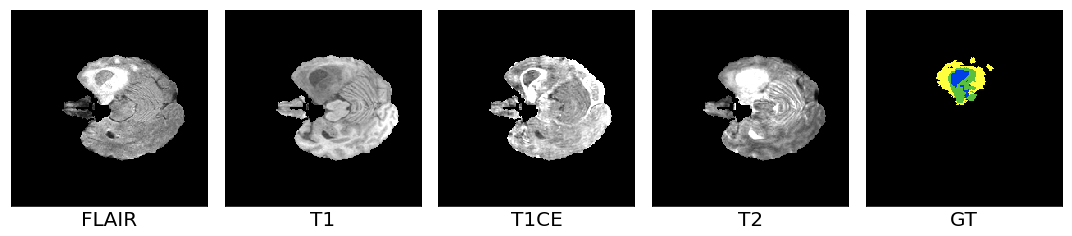

In [77]:
tst_path = '/home/kevinteng/Desktop/ssd02/BraTS2020_preprocessed03/Training_pre/BraTS20_Training_001.npy'
tst_npy = np.load(tst_path)
print(tst_npy.shape)

idx=50
input_img = [tst_npy[idx,:,:,i] for i in range(4)]
input_img.append(plot_labels_color(tst_npy[idx,:,:,-1]))
caption = ["FLAIR", "T1", "T1CE", "T2", "GT"]
plot_comparison(input_img, caption,
                save_path = '/home/kevinteng/Desktop/ssd02/eps/',
                save_name='input_data', save_as = 'png', save_dpi=600,
                n_col = len(caption), figsize=(15,15))

---

# Grid Plot

In [23]:
def grid_plot_brain(patient_id_list, slice_idx_list, ver,
                    mode='training', captions=None,
                    captions_font=20, crop_top = 20,
                    crop_bottom= 20, crop_left = 20,
                    crop_right = 20, save_as='png',
                    save_name=None, save_dpi = 600,
                    figsize=(18, 18), axes_pad=0.05):
    input_imgs = []
    for patient_id in patient_id_list:
        if mode=='validation':
            img_data = '/home/kevinteng/Desktop/ssd02/BraTS2020_preprocessed03/Validation_pre/BraTS20_Validation_{}.npy'.format(patient_id)
            img_seg ='/home/kevinteng/Desktop/ssd02/submission/Validation_pre_{}/BraTS20_Validation_{}.nii.gz'.format(ver, patient_id)
            #
        elif mode=='training':
            img_data = '/home/kevinteng/Desktop/ssd02/BraTS2020_preprocessed03/Training_pre/BraTS20_Training_{}.npy'.format(patient_id)
            img_seg = '/home/kevinteng/Desktop/ssd02/submission/Training_pre_{}/BraTS20_Training_{}.nii.gz'.format(ver, patient_id)
        #
        img_npy = np.load(img_data)
        predict_seg,_ = medpy.io.load(img_seg)
        img_size = predict_seg.shape[1]
        for slice_idx in slice_idx_list:
            #append modalities Flair, t1, t1ce, t2
            for i in range(4):
                input_imgs.append(img_npy[slice_idx,crop_top:img_size-crop_bottom,crop_left:img_size-crop_right,i])
            if mode=='training':
                #append flair with GT
                input_imgs.append(show_lable_on_image4(img_npy[slice_idx,crop_top:img_size-crop_bottom,crop_left:img_size-crop_right,0]
                                                       ,img_npy[slice_idx,crop_top:img_size-crop_bottom,crop_left:img_size-crop_right,-1]))
            #append flair with predicted seg
            input_imgs.append(show_lable_on_image4(img_npy[slice_idx,crop_top:img_size-crop_bottom,crop_left:img_size-crop_right,0]
                                                   ,predict_seg[crop_top:img_size-crop_bottom,crop_left:img_size-crop_right,slice_idx]))

    fig = plt.figure(figsize=figsize)
    nimgs = len(input_imgs)
    if mode=='validation':
        ncols = 5 #without labels(flair, t1, t1ce, t2, predicted labels)
    elif mode=='training':
        ncols = 6 #with labels(flair, t1, t1ce, t2, gt, predicted labels)
    nrows = nimgs//ncols 
    grid = ImageGrid(fig, 111, nrows_ncols=(nrows, ncols), axes_pad=axes_pad)
    
    cap_idx = 0
    for steps,(ax, im) in enumerate(zip(grid,input_imgs)):
        for i in range(0,nimgs,ncols):
            #modalities should be in gray scale as well
            if steps<i+4:
                ax.imshow(im, cmap='gray')
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                ax.imshow(im)
                ax.set_xticks([])
                ax.set_yticks([])
        if (captions is not None and steps>=nimgs-ncols and cap_idx<len(captions)):
            ax.set_xlabel(captions[cap_idx], fontsize=captions_font)
            cap_idx+=1
    #save as high res format
    if save_as!=None:
        plt.savefig('/home/kevinteng/Desktop/ssd02/eps/{}.{}'.format(save_name, save_as), 
                    format=save_as, save_dpi=save_dpi)
    plt.show()

## For Paper

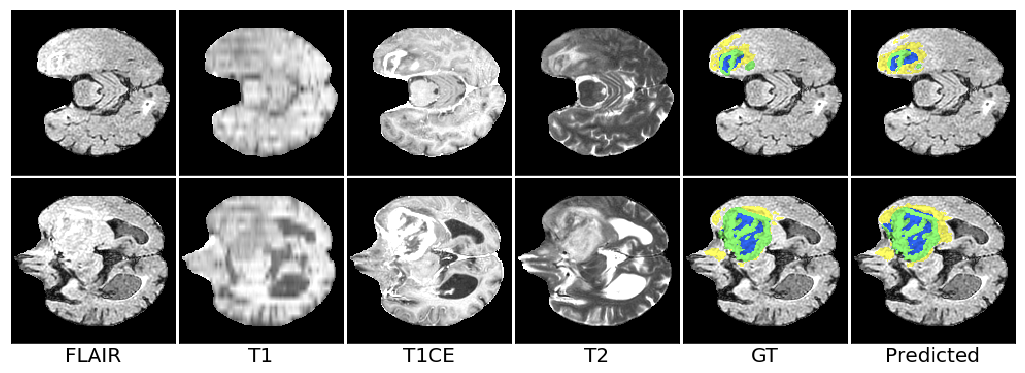

In [18]:
#version used for submission outputs
ver = 'DeepSupervisedAttentionUNet02'

patient_id_list = [338]
slice_idx_list = [50,65]
captions = ['FLAIR', 'T1', 'T1CE', 'T2', 'GT', 'Predicted']

grid_plot_brain(patient_id_list, slice_idx_list, ver, mode='training', captions=captions, 
                crop_top = 40, crop_bottom= 40, crop_left = 60,crop_right = 20,
                save_name='training_output_grid', save_as='eps', save_dpi = 600)

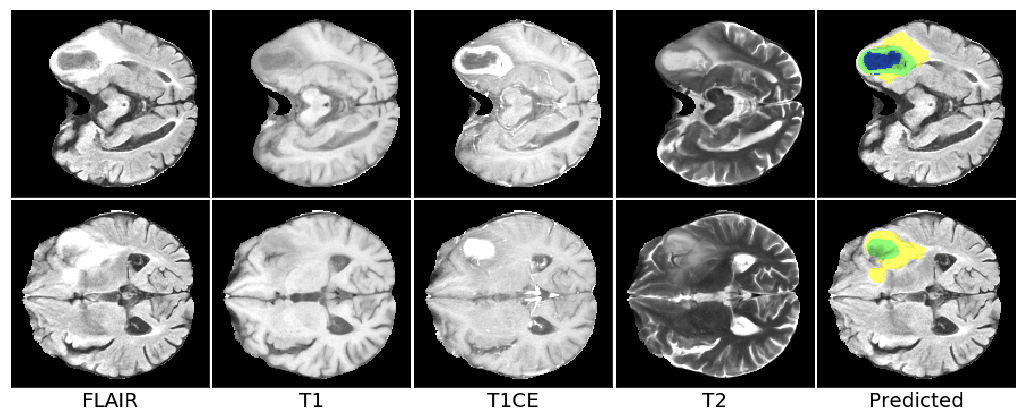

In [23]:
patient_id_list = ['024']
slice_idx_list = [50,65]
captions = ['FLAIR', 'T1', 'T1CE', 'T2','Predicted']

grid_plot_brain(patient_id_list, slice_idx_list, ver, mode='validation', captions=captions, 
                crop_top = 35, crop_bottom= 40, crop_left = 45,crop_right = 20,
                save_name='validation_output_grid', save_as='eps', save_dpi = 600)

## For Kickoff Presentation

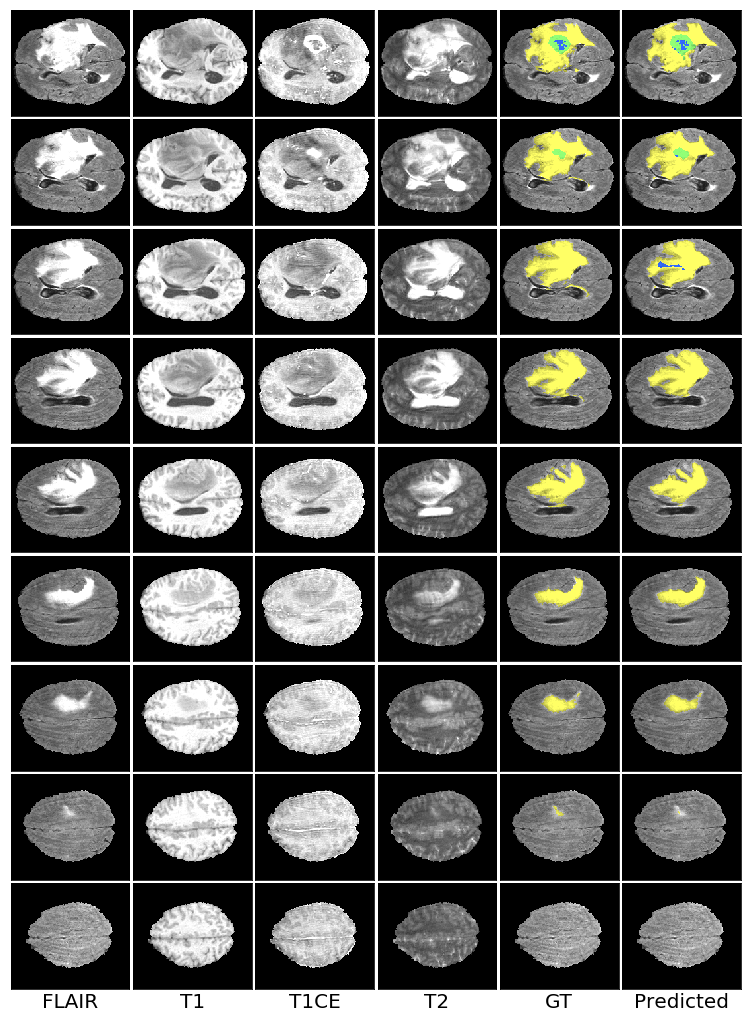

In [30]:
#version used for submission outputs
ver = 'DeepSupervisedAttentionUNet02'

patient_id_list = ['001']
slice_idx_list = [i for i in range(75,120,5)]
captions = ['FLAIR', 'T1', 'T1CE', 'T2', 'GT', 'Predicted']

grid_plot_brain(patient_id_list, slice_idx_list, ver, mode='training', captions=captions, 
                crop_top = 40, crop_bottom= 40, crop_left = 40,crop_right = 20,
                save_name='training_output_grid_kickoff75_120', save_as='png', save_dpi = 600)

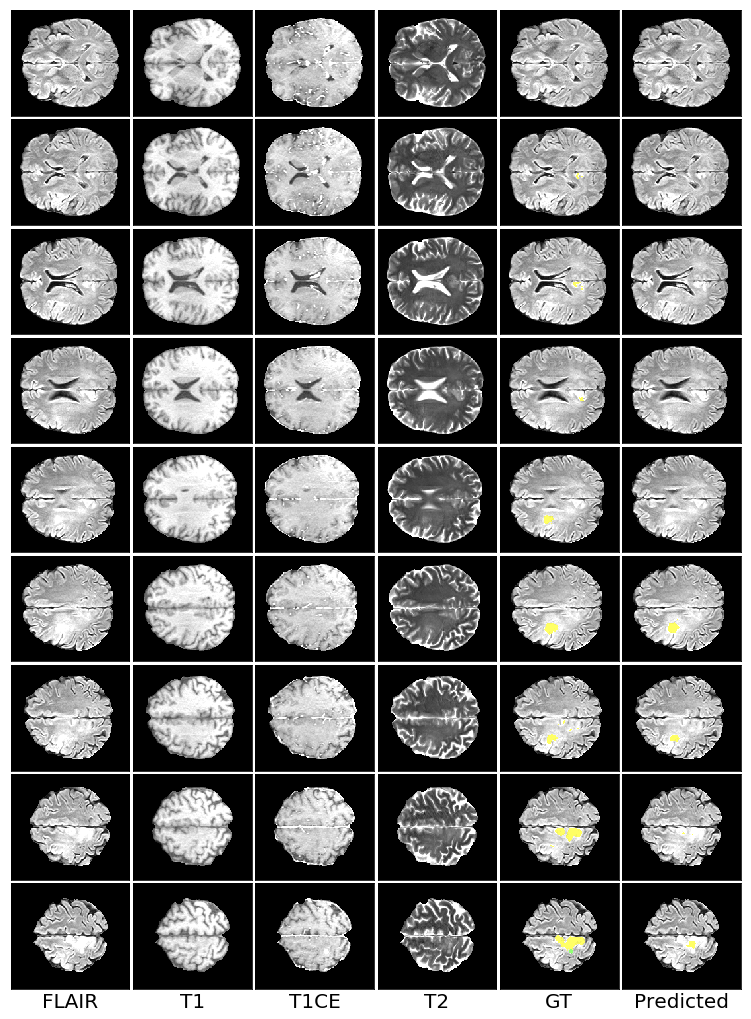

In [37]:
#version used for submission outputs
ver = 'DeepSupervisedAttentionUNet02'

patient_id_list = ['110']
slice_idx_list = [i for i in range(75,120,5)]
captions = ['FLAIR', 'T1', 'T1CE', 'T2', 'GT', 'Predicted']

grid_plot_brain(patient_id_list, slice_idx_list, ver, mode='training', captions=captions, 
                crop_top = 40, crop_bottom= 40, crop_left = 40,crop_right = 20,
                save_name='training_output_grid_kickoff110_75_120', save_as='png', save_dpi = 600)

# Label Distribution 

In [2]:
train_ds = '/home/kevinteng/Desktop/ssd02/MICCAI_BraTS2020_TrainingData/'

label_counts00 = []
label_counts01 = []
label_counts02 = []
label_counts04 = []
for patient in sorted(os.listdir(train_ds)):
    merge_01 = os.path.join(train_ds,patient+'/')
    #skip .csv file
    if merge_01 == glob.glob(train_ds+'*.csv')[0]+ '/' or merge_01 == glob.glob(train_ds+'*.csv')[1]+ '/':
        continue
    seg_path = glob.glob(merge_01+'*seg.nii.gz')[0]
    seg,_ = medpy.io.load(seg_path)
    unique, counts = np.unique(seg, return_counts=True)
    if len(counts)!=4:
        pad = np.array([0])
        counts = np.concatenate((counts,pad))
    label_counts00.append(counts[0])
    label_counts01.append(counts[1])
    label_counts02.append(counts[2])
    label_counts04.append(counts[3])
    

label_00 = np.sum(label_counts00)
label_01 = np.sum(label_counts01)
label_02 = np.sum(label_counts02)
label_04 = np.sum(label_counts04)

print("Number of patients: {}".format(len(label_counts00)))
print("Number of label 0: {}".format(label_00))
print("Number of label 1: {}".format(label_01))
print("Number of label 2: {}".format(label_02))
print("Number of label 4: {}".format(label_04))

Number of patients: 369
Number of label 0: 3257699276
Number of label 1: 8168271
Number of label 2: 21298475
Number of label 4: 7265978


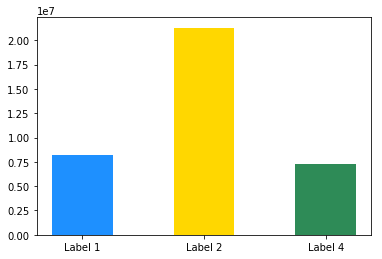

In [8]:
captions = ['Label 1', 'Label 2', 'Label 4']
labels = [8168271, 21298475, 7265978]
plt.bar(captions, labels, color=['dodgerblue', 'gold', 'seagreen'], width=0.5)
plt.xticks()
plt.savefig('/home/kevinteng/Desktop/ssd02/eps/{}.{}'.format('bar_plot', 'eps'), save_dpi=600)
plt.show()

---

# Gif Plot

In [17]:
def gif_plot(img_path, output_path, save_name, mode='modality', fps=10):
    img_npy,_ = medpy.io.load(img_path)
    if mode=='modality':
        norm_img = min_max_norm(img_npy)
        norm_img = np.einsum('ijk->kij', norm_img)
        norm_img = norm_img*255
        images = []
        for img in norm_img:
            frame = Image.fromarray(img)
            frame = frame.convert("L")
            images.append(frame)
        images[0].save(output_path+'{}.gif'.format(save_name),save_all=True,
                       append_images=images[1:],
                       duration=int((1000)/fps),
                       loop=0)
    if mode=='segmentation':
        seg_npy,_ = medpy.io.load(img_path)
        seg_npy = np.einsum('ijk->kij', seg_npy)
        images = []
        for img in seg_npy:
            img = plot_labels_color255(img).astype(np.uint8)
            frame = Image.fromarray(img)
            images.append(frame)
        images[0].save(output_path+'{}.gif'.format(save_name),save_all=True,
                       append_images=images[1:],
                       duration=int((1000)/fps),
                       loop=0)

## Patient training_001

In [22]:
#call only patient id 001 from training dataset
img_path = '/home/kevinteng/Desktop/ssd02/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii.gz'
output_path = '/home/kevinteng/Desktop/'
save_name = 'Flair_bt'
gif_plot(img_path, output_path, save_name, mode='modality', fps=5)

In [19]:
img_path = '/home/kevinteng/Desktop/ssd02/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii.gz'
output_path = '/home/kevinteng/Desktop/'
save_name = 'seg_bt'
gif_plot(img_path, output_path, save_name, mode='segmentation', fps=5)

In [18]:
img_path = '/home/kevinteng/Desktop/ssd02/submission/Training_pre_DeepSupervisedAttentionUNet02/BraTS20_Training_001.nii.gz'
output_path = '/home/kevinteng/Desktop/'
save_name = 'seg_pred'
gif_plot(img_path, output_path, save_name, mode='segmentation', fps=5)

## Patient training_110

In [32]:
#call only patient id 114from training dataset
img_path = '/home/kevinteng/Desktop/ssd02/MICCAI_BraTS2020_TrainingData/BraTS20_Training_110/BraTS20_Training_110_flair.nii.gz'
output_path = '/home/kevinteng/Desktop/'
save_name = 'Flair_bt_110'
gif_plot(img_path, output_path, save_name, mode='modality', fps=5)

In [33]:
img_path = '/home/kevinteng/Desktop/ssd02/MICCAI_BraTS2020_TrainingData/BraTS20_Training_110/BraTS20_Training_110_seg.nii.gz'
output_path = '/home/kevinteng/Desktop/'
save_name = 'seg_bt_110'
gif_plot(img_path, output_path, save_name, mode='segmentation', fps=5)

In [34]:
img_path = '/home/kevinteng/Desktop/ssd02/submission/Training_pre_DeepSupervisedAttentionUNet02/BraTS20_Training_110.nii.gz'
output_path = '/home/kevinteng/Desktop/'
save_name = 'seg_pred_110'
gif_plot(img_path, output_path, save_name, mode='segmentation', fps=5)

---

# 3D Plot

In [75]:
from skimage import measure
#https://medium.com/@hengloose/a-comprehensive-starter-guide-to-visualizing-and-analyzing-dicom-images-in-python-7a8430fcb7ed
img_path = '/home/kevinteng/Desktop/ssd02/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii.gz'
img_npy,_ = medpy.io.load(img_path)
# img_npy = np.einsum('ijk->kji', img_npy)
verts, faces, _, _ = measure.marching_cubes_lewiner(img_npy, 0)

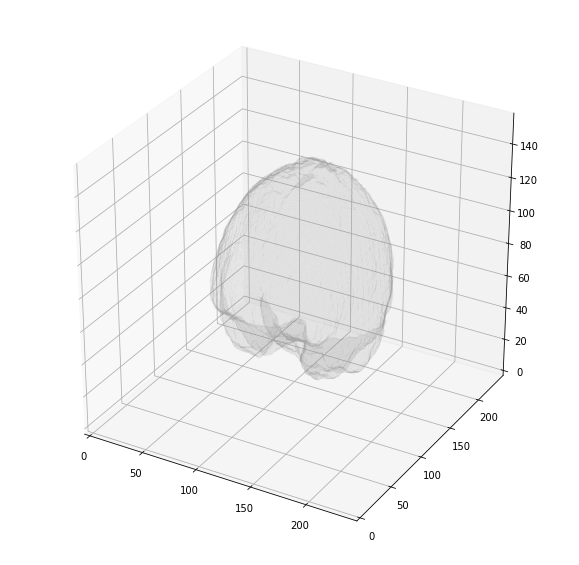

In [76]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection 
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# Fancy indexing: `verts[faces]` to generate a collection of    
# triangles
mesh = Poly3DCollection(verts[faces], alpha=0.1)
face_color = [0.66,0.66,0.66]
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)
ax.set_xlim(0, 240)
ax.set_ylim(0, 240)
ax.set_zlim(0, 155)
plt.show()